In [ ]:
!pip install --quiet vit-keras
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 6.8 MB/s eta 0:00:00


Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import pandas as pd
import numpy as np
import keras
from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dropout, Dense, LayerNormalization, Flatten
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from vit_keras import vit
import tensorflow_addons as tfa
import math
import os
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
from zipfile import ZipFile
import time
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import  precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import backend as K

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Initializing the ViT Model

In [ ]:
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

347502902/347502902 [==============================] - 7s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Adding Additional layers on top of ViT Model

In [ ]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 11)                8459      
                                                                 
 batch_normalization_1 (Batc  (None, 11)               44        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 2)          

Compiling the model using Focal Loss

In [ ]:
def focal_loss(gamma=2, alpha=0.5):
    def focal_loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        focal_loss = -alpha * y_true * K.pow(1.0 - y_pred, gamma) * K.log(y_pred)
        return K.mean(focal_loss, axis=-1)
    return focal_loss_fn

# Replace the loss function in your model with focal loss
model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

Function for plotting the graph of loss and accuracy

In [ ]:
def graph_it(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Model Accuracy: Training and Validation')
  plt.legend(loc=0)
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation Loss')
  plt.legend(loc=0)
  plt.figure()


Function for evaluation of model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, precision_score, roc_curve, ConfusionMatrixDisplay

def test_it(model, test_generator):
    test_labels = test_generator.classes

    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)

    cm = confusion_matrix(test_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()



    roc = roc_auc_score(test_labels, predictions[:, 1])  # Assuming binary classification

    # Calculate confusion matrix CHANGE THIS TO CM
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    report = classification_report(test_labels, predicted_labels)

    precision = precision_score(test_labels, predicted_labels, average='weighted')

    print("\n", report)
    print(f"Sensitivity: {round(sensitivity, 3)} Specificity: {round(specificity, 3)} Precision: {round(precision, 3)} ROC_AUC_SCORE: {round(roc, 3)}\n")

    # Plot AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Set the directories for the data for task1 (SEB VS NEVUS)
train_dir = "/content/drive/MyDrive/msc_project/train_splited_augumented"
test_dir = "/content/drive/MyDrive/msc_project/test_splited"
val_dir = "/content/drive/MyDrive/msc_project/val_splited"

In [ ]:
# Define the data generator
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

image_size = (224, 224)
batch = 32

In [ ]:
model_path = f'/content/drive/MyDrive/msc_project/model/{title}'
os.makedirs(model_path, exist_ok=True)

Generating images into batches to feed the model

In [ ]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_dir,
                                            target_size=(image_size),
                                            batch_size=10)

valid_batches = datagen.flow_from_directory(test_dir,
                                            target_size=(image_size),
                                            batch_size=10)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(test_dir,
                                            target_size=(image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 9763 images belonging to 2 classes.
Found 483 images belonging to 2 classes.
Found 483 images belonging to 2 classes.


In [ ]:
train_batches.class_indices

{'nevu': 0, 'seb': 1}

In [ ]:
valid_batches.class_indices

{'nevu': 0, 'seb': 1}

In [ ]:
from collections import Counter

class_counts = Counter(train_batches.classes)
print("Number of images per class:", class_counts)


Number of images per class: Counter({0: 8232, 1: 1531})


In [ ]:
class_names = list(train_batches.class_indices.keys())
class_counts_with_names = {class_names[idx]: count for idx, count in class_counts.items()}
print("Number of images per class:", class_counts_with_names)

Number of images per class: {'nevu': 8232, 'seb': 1531}


Calculating the train, validation and test steps

In [ ]:
train_steps = np.ceil(train_batches.n / batch)
test_steps = np.ceil(test_batches.n / batch)
val_steps = np.ceil(valid_batches.n / batch)

Configuration of Early stopping criteria, learning rate

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',patience=8)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = 'model.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

def step_decay(epoch):
    initial_lrate = 0.00002
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [ ]:
callbacks = [early_stopping, checkpointer, lr_scheduler]

Model Training

In [ ]:
history = model.fit_generator(train_batches, steps_per_epoch=train_steps,
                              validation_data=valid_batches,
                              validation_steps=test_steps,
                              epochs=30,
                              callbacks=callbacks)

<ipython-input-22-13082ddda168>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_batches, steps_per_epoch=train_steps,



Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
306/306 [==============================] - ETA: 0s - loss: 0.0590 - accuracy: 0.5965
Epoch 1: val_accuracy improved from -inf to 0.58125, saving model to model.hdf5
306/306 [==============================] - 457s 1s/step - loss: 0.0590 - accuracy: 0.5965 - val_loss: 0.0610 - val_accuracy: 0.5813 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.0404 - accuracy: 0.6793
Epoch 2: val_accuracy improved from 0.58125 to 0.81875, saving model to model.hdf5
306/306 [==============================] - 211s 689ms/step - loss: 0.0404 - accuracy: 0.6793 - val_loss: 0.0314 - val_accuracy: 0.8188 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 2e-05.
Epoch 3/30
306/306 [==============================] - ETA: 0s - loss: 0.0361 - accuracy: 0.7196
Epoch 3: val_accuracy did not improve from 0.81875
306/3

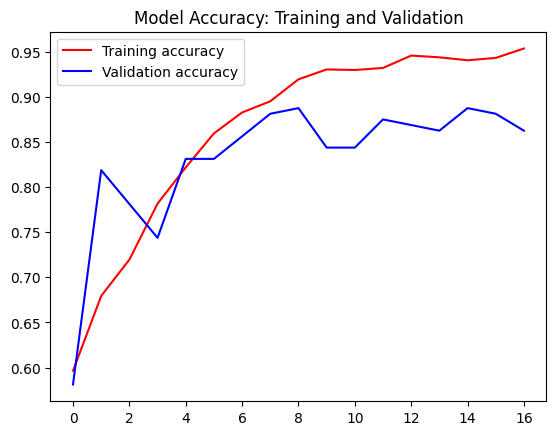

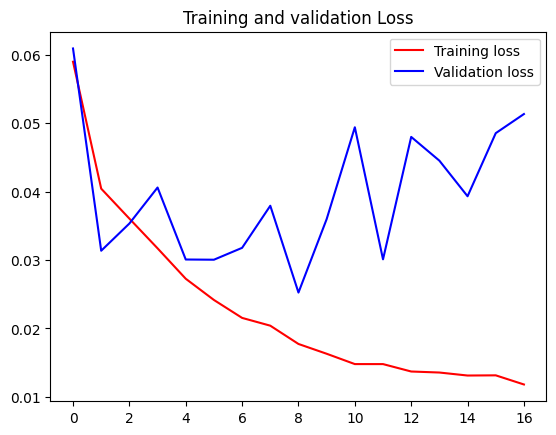

<Figure size 640x480 with 0 Axes>

In [ ]:
graph_it(history)

**Model Evaluation using test data**

483/483 [==============================] - 22s 41ms/step


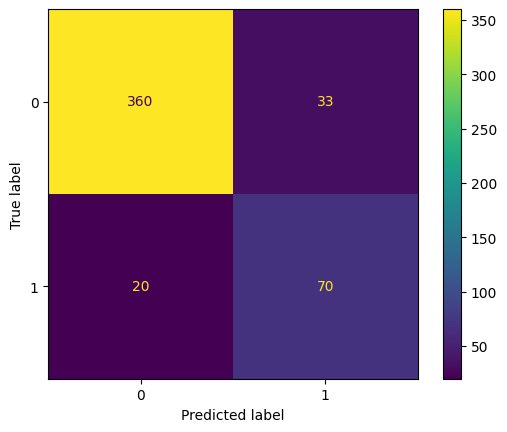


               precision    recall  f1-score   support

           0       0.95      0.92      0.93       393
           1       0.68      0.78      0.73        90

    accuracy                           0.89       483
   macro avg       0.81      0.85      0.83       483
weighted avg       0.90      0.89      0.89       483

Sensitivity: 0.778 Specificity: 0.916 Precision: 0.897 ROC_AUC_SCORE: 0.929



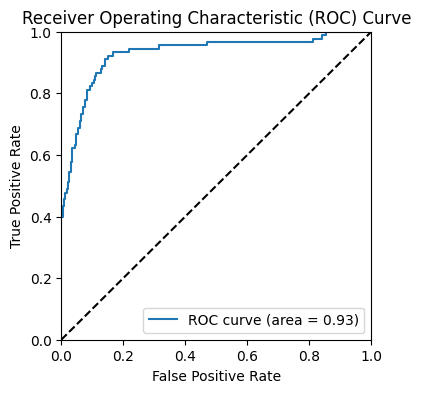

In [ ]:
model.load_weights(filepath = 'model.hdf5')
test_it(model, test_batches)

In [ ]:
from sklearn.metrics import confusion_matrix

predictions = model.predict_generator(test_batches, steps=len(test_batches), verbose=1)

y_pred = np.argmax(predictions, axis=1)
targetnames = ['mel','sb_nv']
y_true = test_batches.classes

cm1 = confusion_matrix(y_true,y_pred)
print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[1,0])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,1]+cm1[0,1])
print('Specificity : ', specificity1)

  3/483 [..............................] - ETA: 19s

<ipython-input-25-3377af50feee>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_batches, steps=len(test_batches), verbose=1)


483/483 [==============================] - 18s 38ms/step
Confusion Matrix : 
 [[360  33]
 [ 20  70]]
Accuracy :  0.8902691511387164
Sensitivity :  0.9473684210526315
Specificity :  0.6796116504854369
